In [1]:
import numpy as np
from PIL import Image
import taichi as ti
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from utils import run_optimization, resample_polyline, get_area

ti.init(arch=ti.gpu)

[Taichi] version 1.7.3, llvm 15.0.1, commit 5ec301be, win, python 3.12.3
[Taichi] Starting on arch=cuda


(-1.3375, 0.5875, -0.55, 0.55)

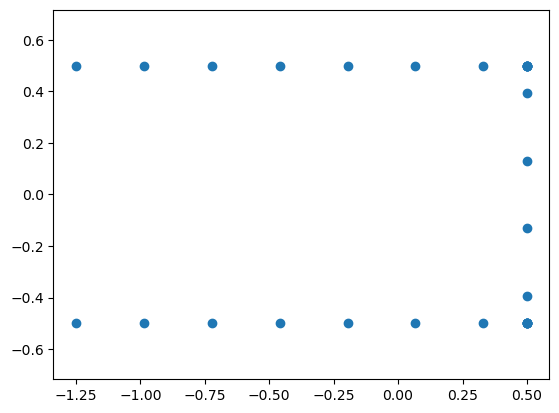

In [7]:
def init_trajectory(sofa_w, sofa_h, control_point_num, middle_rotation=-0.5 * np.pi, offset=1):  # 生成初始轨迹
    xs, ys, rotations = resample_polyline([
        [-sofa_w / 2, 0.5, 0],
        [0.5, 0.5, 0],
        [0.5, 0.5, middle_rotation],
        [0.5, 0.5 - offset, middle_rotation],
        [0.5, 0.5 - offset, middle_rotation * 2],
        [-sofa_w / 2, 0.5 - offset, middle_rotation * 2]
    ], control_point_num).T
    return xs, ys, rotations

offset = 1  # 前后走廊中线的距离

sofa_w = 2.5   # 求解域的尺寸
sofa_h = 1.0   # 求解域的尺寸

xs, ys, rotations = init_trajectory(  # 初始轨迹
    sofa_w=sofa_w,
    sofa_h=sofa_h,
    control_point_num=30,  # 轨迹的控制点数量
    offset=offset
)

plt.scatter(xs, ys)
plt.axis('equal')

In [ ]:
# xs, ys, rotations = np.load('../trajectory/180°拐角/sofa_900.npy')

In [ ]:
assert offset == 1

@ti.func
def is_forbidden(x1, y1, x2, y2):  # 指定哪里是墙
    return y2 < -1 or y2 > 1 or x2 > 1 or (x2 < 0 and y1 * y2 < 0)  # 括号里的内容制定了无穷薄但不能穿过的墙

best_score, xs, ys, rotations, sofa, maximal_area_record = run_optimization(
    is_forbidden,
    xs,
    ys,
    rotations,
    # initial_xs=zoom(xs, zoom=2, order=1),
    # initial_ys=zoom(ys, zoom=2, order=1),
    # initial_rotations=zoom(rotations, zoom=2, order=1),
    sofa_w=sofa_w,
    sofa_h=sofa_h,
    mutation_sigma_pos = 0.02,  # 变异率
    mutation_sigma_rotation = 0.004,  # 变异率
    iterations = 200000,  # 200000
    trajectory_upsampling=41,  # 41 101
    resolution=1024,  # 1024 2000
    print_every=500,  # 1000
    save_image_every=83,
    save_image_path='../images/180°拐角/sofa_',
    save_image_start_id=0,
    save_trajectory_path='../trajectory/180°拐角/sofa_'
)
print(f"Estimated maximal sofa area (by sampling): {best_score:.5f}")
# save mask image as PNG if pillow is available

img = (sofa * 255).astype(np.uint8)
im = Image.fromarray(img.T[::-1])
im.save('../sofa_survivors.png')
print('../Saved sofa_survivors.png')
plt.plot(maximal_area_record)